In [2]:
#! pip install --user scikit-learn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Loading datasets

In [4]:
# Temperature, Precipitation, Potential Evaporation (PET)
Temp_RH_PET = pd.read_csv('Outputs/Temp_RH_PET.csv', index_col=['HYBAS_ID'])
#Temp_RH_PET.head()

In [5]:
# indices, soil parameters
params_ind_soil = pd.read_csv('Outputs/params_ind_soil.csv', index_col='HYBAS_ID')
del params_ind_soil['Unnamed: 0']
#params_ind_soil.head()

In [6]:
# land uses
land_uses = pd.read_csv('Outputs/land_uses_perc.csv', index_col=['HYBAS_ID'])
del land_uses['Unnamed: 0']
#land_uses.head()

In [7]:
# Shapes of dataframes
print('The shape of land_uses df is {0}'.format(land_uses.shape))
print('The shape of Temp_RH_PET df is {0}'.format(Temp_RH_PET.shape))
print('The shape of params_ind_soil df is {0}'.format(params_ind_soil.shape))

The shape of land_uses df is (28, 5)
The shape of Temp_RH_PET df is (24, 36)
The shape of params_ind_soil df is (27, 9)


In [8]:
# Merging the data
merge_1 = params_ind_soil.merge(land_uses, on='HYBAS_ID', how='inner')
merge_all = merge_1.merge(Temp_RH_PET, on='HYBAS_ID', how='inner')
merge_all.shape

(23, 50)

<AxesSubplot:>

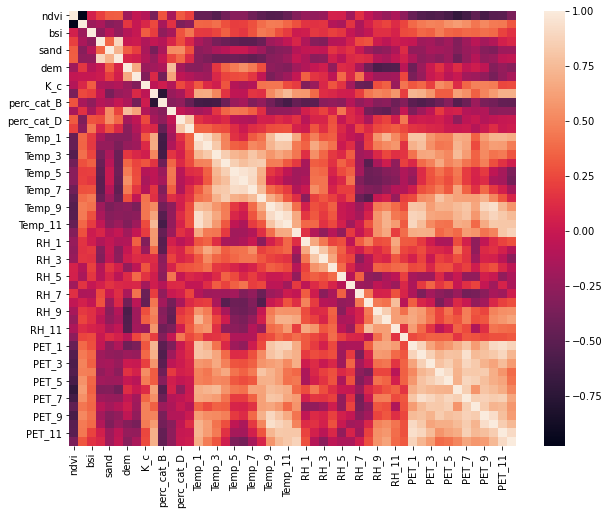

In [9]:
import seaborn as sns

# Correlation_matrix
corr  = merge_all.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, ax=ax)

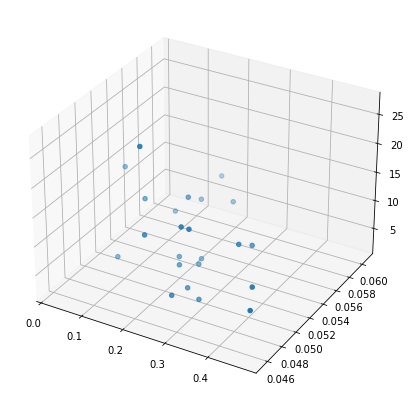

In [10]:
# 3-D plots are useful to provide deep insights about the data
fig = plt.figure(figsize=(7, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(merge_all.ndvi, merge_all.PET_2, merge_all.slope)
plt.show()

# Applying k-means 

In [11]:
import sklearn
from sklearn.cluster import KMeans 

k_means = KMeans(init = "k-means++", n_clusters = 4, n_init = 12)
k_means.fit(merge_all.values)

KMeans(n_clusters=4, n_init=12)

In [12]:
k_means_labels = k_means.labels_
k_means_labels

array([0, 0, 1, 0, 0, 0, 0, 2, 3, 0, 2, 2, 0, 0, 3, 2, 3, 0, 1, 0, 1, 1,
       2])

In [13]:
k_means_cluster_centers = k_means.cluster_centers_
k_means_cluster_centers.shape

(4, 50)

In [14]:
k_means_cluster_centers

array([[ 2.07352273e-01, -1.96969453e-01, -1.71389501e-01,
         3.02851509e-01,  1.01001667e+00,  8.20340369e-01,
         5.70526077e-01,  5.65897951e+00,  1.70940637e+00,
         2.50188996e-01,  6.45745225e-01,  5.54149089e-02,
         1.12847978e-02,  3.73654467e-02,  4.07519756e+00,
         3.97325724e+00,  6.21509785e+00,  9.87898053e+00,
         1.33809170e+01,  1.63421750e+01,  1.81550203e+01,
         1.80691755e+01,  1.50858350e+01,  1.16252922e+01,
         7.38424931e+00,  5.66476568e+00,  1.01528931e-01,
         8.72883685e-02,  6.75239288e-02,  5.20879630e-02,
         6.94979369e-02,  9.63912338e-02,  1.00956069e-01,
         1.16367302e-01,  1.04668939e-01,  1.08188219e-01,
         9.28883204e-02,  1.16262665e-01,  3.32596066e-02,
         5.33757797e-02,  8.84138152e-02,  1.41269987e-01,
         1.75625914e-01,  1.82014308e-01,  1.83864070e-01,
         1.58516359e-01,  1.13309103e-01,  6.77550867e-02,
         3.73862034e-02,  3.15765421e-02],
       [ 2.78

In [15]:
# from mpl_toolkits.mplot3d import Axes3D 
# fig = plt.figure(1, figsize=(8, 6))
# plt.clf()
# ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plt.cla()
# # plt.ylabel('Age', fontsize=18)
# # plt.xlabel('Income', fontsize=16)
# # plt.zlabel('Education', fontsize=16)
# ax.set_xlabel('Education')
# ax.set_ylabel('Age')
# ax.set_zlabel('Income')

# ax.scatter(X[:, 1], X[:, 0], X[:, 3], c= labels.astype(np.float))

[[0.61960784 0.00392157 0.25882353 1.        ]
 [0.99346405 0.74771242 0.43529412 1.        ]
 [0.74771242 0.89803922 0.62745098 1.        ]
 [0.36862745 0.30980392 0.63529412 1.        ]]
the cluster center is [ 2.07352273e-01 -1.96969453e-01 -1.71389501e-01  3.02851509e-01
  1.01001667e+00  8.20340369e-01  5.70526077e-01  5.65897951e+00
  1.70940637e+00  2.50188996e-01  6.45745225e-01  5.54149089e-02
  1.12847978e-02  3.73654467e-02  4.07519756e+00  3.97325724e+00
  6.21509785e+00  9.87898053e+00  1.33809170e+01  1.63421750e+01
  1.81550203e+01  1.80691755e+01  1.50858350e+01  1.16252922e+01
  7.38424931e+00  5.66476568e+00  1.01528931e-01  8.72883685e-02
  6.75239288e-02  5.20879630e-02  6.94979369e-02  9.63912338e-02
  1.00956069e-01  1.16367302e-01  1.04668939e-01  1.08188219e-01
  9.28883204e-02  1.16262665e-01  3.32596066e-02  5.33757797e-02
  8.84138152e-02  1.41269987e-01  1.75625914e-01  1.82014308e-01
  1.83864070e-01  1.58516359e-01  1.13309103e-01  6.77550867e-02
  3.73862

NameError: name 'merge_2' is not defined

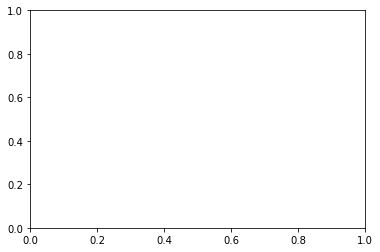

In [16]:
fig = plt.figure(figsize=(6, 4))
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

print(colors)

ax = fig.add_subplot(1, 1, 1)

for k in range(len(k_means_labels)):

    my_members = (k_means_labels == k)
    cluster_center = k_means_cluster_centers[k]
    print('the cluster center is',cluster_center)
    print(merge_2[my_members].iloc[:,1])
    print('\n')
    
    ax.plot(merge_2[my_members, 0], merge_2[my_members, 1], 'w', markerfacecolor=col, marker='.')
#     ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=6)

ax.set_title('KMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.show()


In [18]:
cluster_center

array([ 2.07352273e-01, -1.96969453e-01, -1.71389501e-01,  3.02851509e-01,
        1.01001667e+00,  8.20340369e-01,  5.70526077e-01,  5.65897951e+00,
        1.70940637e+00,  2.50188996e-01,  6.45745225e-01,  5.54149089e-02,
        1.12847978e-02,  3.73654467e-02,  4.07519756e+00,  3.97325724e+00,
        6.21509785e+00,  9.87898053e+00,  1.33809170e+01,  1.63421750e+01,
        1.81550203e+01,  1.80691755e+01,  1.50858350e+01,  1.16252922e+01,
        7.38424931e+00,  5.66476568e+00,  1.01528931e-01,  8.72883685e-02,
        6.75239288e-02,  5.20879630e-02,  6.94979369e-02,  9.63912338e-02,
        1.00956069e-01,  1.16367302e-01,  1.04668939e-01,  1.08188219e-01,
        9.28883204e-02,  1.16262665e-01,  3.32596066e-02,  5.33757797e-02,
        8.84138152e-02,  1.41269987e-01,  1.75625914e-01,  1.82014308e-01,
        1.83864070e-01,  1.58516359e-01,  1.13309103e-01,  6.77550867e-02,
        3.73862034e-02,  3.15765421e-02])

In [19]:
cluster_centers_

NameError: name 'cluster_centers_' is not defined

In [ ]:
(merge_2[my_members].iloc[:,1])

In [ ]:
# merge_2[my_members]

In [20]:
# Add the slider - SOS

# Performance

K-Means is a distance-based algorithm. Because of that, it’s important to normalize, standardize, or choose any other option in which the distance has some comparable meaning for all the columns. MinMaxScaler, it’s an excellent tool for it.

# Inertia

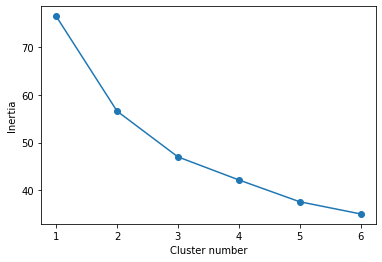

In [21]:
# Inertia was calculated to determine the most suitable number of clusters
from sklearn.preprocessing import MinMaxScaler

X=merge_all.reset_index(drop=True)
scaler = MinMaxScaler()
scaler.fit(X)
X=scaler.transform(X)
inertia = []
for i in range(1,7):
    kmeans = KMeans(
        n_clusters=i, init="k-means++",
        n_init=10,
        tol=1e-04, random_state=42
    )
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

fig, ax = plt.subplots()
ax.plot(inertia, '-o')
ax.set_xlabel('Cluster number')
ax.set_ylabel('Inertia')
plt.xticks(np.arange(0,6), np.arange(1,7));
# the elbow shows up when number of clusters equals 3

# Applying k-means for n_clusters=3

In [22]:
# line polar

In [23]:
merge_all.columns

Index(['ndvi', 'ndwi', 'bsi', 'clay', 'sand', 'silt', 'dem', 'slope', 'K_c',
       'perc_cat_A', 'perc_cat_B', 'perc_cat_C', 'perc_cat_D', 'perc_cat_E',
       'Temp_1', 'Temp_2', 'Temp_3', 'Temp_4', 'Temp_5', 'Temp_6', 'Temp_7',
       'Temp_8', 'Temp_9', 'Temp_10', 'Temp_11', 'Temp_12', 'RH_1', 'RH_2',
       'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9', 'RH_10',
       'RH_11', 'RH_12', 'PET_1', 'PET_2', 'PET_3', 'PET_4', 'PET_5', 'PET_6',
       'PET_7', 'PET_8', 'PET_9', 'PET_10', 'PET_11', 'PET_12'],
      dtype='object')

In [24]:
kmeans = KMeans(
        n_clusters=3, init="k-means++",
        n_init=10,
        tol=1e-04, random_state=42
    )
kmeans.fit(X)
clusters=pd.DataFrame(X,columns=merge_all.columns)
clusters['label']=kmeans.labels_
clusters
polar=clusters.groupby("label").mean().reset_index()
polar


,label,ndvi,ndwi,bsi,clay,sand,silt,dem,slope,K_c,...,PET_3,PET_4,PET_5,PET_6,PET_7,PET_8,PET_9,PET_10,PET_11,PET_12
0,0,0.399998,0.549852,0.520642,0.049663,0.223229,0.094664,0.330589,0.311348,0.140886,...,0.546314,0.507998,0.532788,0.611404,0.504704,0.541889,0.568819,0.511826,0.371109,0.261228
1,1,0.350251,0.629408,0.529988,0.098052,0.077350,0.125934,0.112877,0.194104,0.292127,...,0.702225,0.588202,0.726565,0.738023,0.807468,0.768179,0.744508,0.855180,0.757247,0.589057
2,2,0.664150,0.344966,0.292946,0.282578,0.362293,0.378820,0.314203,0.314531,0.154143,...,0.325881,0.272913,0.336994,0.166879,0.219701,0.432178,0.245477,0.240488,0.207582,0.222172


In [25]:
polar=pd.melt(polar,id_vars=["label"])
polar

,label,variable,value
0,0,ndvi,0.399998
1,1,ndvi,0.350251
2,2,ndvi,0.664150
3,0,ndwi,0.549852
4,1,ndwi,0.629408
...,...,...,...
145,1,PET_11,0.757247
146,2,PET_11,0.207582
147,0,PET_12,0.261228
148,1,PET_12,0.589057


In [26]:
pie=clusters.groupby('label').size()

ValueError: 'label' is not a valid value for color

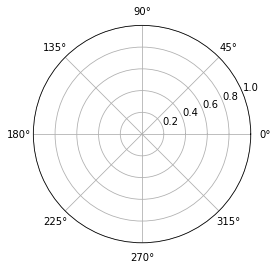

In [27]:
plt.polar(polar, r="value", theta="variable", color="label", line_close=True,height=800,width=1400)

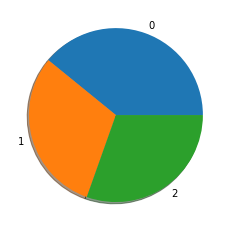

In [29]:
plt.pie(clusters.label.value_counts(), labels=np.arange(0,3), shadow=True);

# Silhouette Coefficient

If the ground truth labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient (sklearn.metrics.silhouette_score) is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:

- a: The mean distance between a sample and all other points in the same class.
- b: The mean distance between a sample and all other points in the next nearest cluster.

The Silhouette Coefficient s for a single sample is then given as:

$$
s=\frac{b-a}{\max (a, b)}
$$

2.3.10.5. Silhouette Coefficient

In [30]:
from sklearn import metrics
Silhouette_ar, calinski_ar, davies_ar = np.zeros(5), np.zeros(5), np.zeros(5)

# silhouette_score requires more than 1 cluster labels.
for i in range(2,7):
    kmeans = KMeans(
        n_clusters=i, init="k-means++",
        n_init=10,
        tol=1e-04, random_state=42
    )
    kmeans.fit(X)
    labels = kmeans.labels_
    Silhouette = metrics.silhouette_score(X, labels, metric='euclidean')
    calinski = metrics.calinski_harabasz_score(X, labels)
    davies = metrics.davies_bouldin_score(X, labels)
    Silhouette_ar[i-2], calinski_ar[i-2], davies_ar[i-2]  = Silhouette, calinski, davies

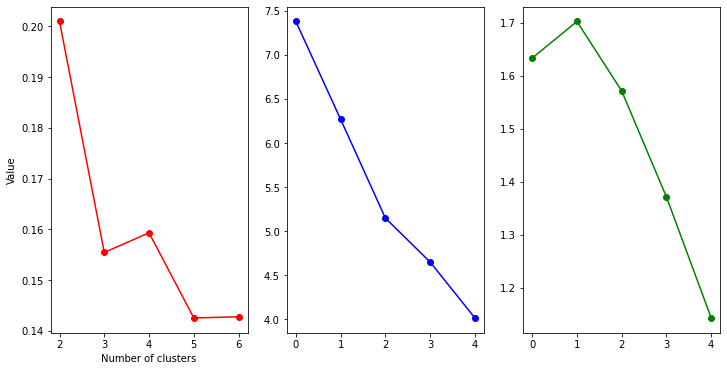

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

plt.subplot(1,3,1)
plt.plot(Silhouette_ar, '-o', color='r')
plt.xlabel('Number of clusters')
plt.ylabel('Value')
plt.xticks(ticks=[0, 1, 2, 3,4], labels=np.arange(2,7));

plt.subplot(1,3,2)
plt.plot(calinski_ar, '-o', color='b')

plt.subplot(1,3,3)
plt.plot(davies_ar, '-o', color='g')

In [32]:
np.arange(2,7)

array([2, 3, 4, 5, 6])

# DBSCAN algorithm

The main concept of DBSCAN algorithm is to locate regions of high density that are separated from one another by regions of low density.

In [33]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

db = DBSCAN(eps=0.3, min_samples=10).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Hierarchical clustering

# T-SNE CLUSTERING

# PCA for visualization

Explained variance for the 1st Principal Component is 35.44 % 
whereas for the second one is 16.13 %


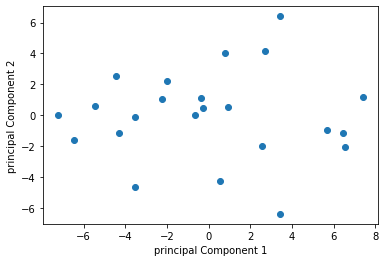

In [67]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns

x_transform = StandardScaler().fit_transform(X)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_transform)

plt.scatter(principalComponents[:,0], principalComponents[:,1])
plt.xlabel('principal Component 1')
plt.ylabel('principal Component 2')
print('Explained variance for the 1st Principal Component is {0:.2f} % \n' \
     'whereas for the second one is {1:.2f} %'.format(pca.explained_variance_ratio_[0]*100,\
                                                    pca.explained_variance_ratio_[1]*100))


# Widgets

In [35]:
import ipywidgets as widgets
from ipywidgets import interact

In [36]:
# def plot_line(showlegend=True, color='b'):
#     plt.plot([0, 1, 2], [0, 1, 0], color, label='Data')
#     if showlegend: plt.legend(loc='best')
        
# interact(plot_line, 
#          showlegend=widgets.Checkbox(value=True, description='Show Legend'),
#          color=widgets.RadioButtons(options=['blue', 'green', 'red'], value='blue', description='Color'));

In [37]:
# Number of clusters - change the plot of points and the cntroids - 2 features - example

https://scikit-learn.org/stable/modules/clustering.html

Calinski-Harabasz Index

The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared):

Davies-Bouldin Index

In [38]:
# Read an old paper - SOS